<a href="https://colab.research.google.com/github/diegofer616/practico01/blob/main/breakout_V0_1_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gymnasium
!pip install ale-py
!pip install gym

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.7 MB/s eta 0:00:00


In [3]:

import gymnasium as gym
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import datetime
from collections import deque
import time
import random
from tqdm import tqdm
from PIL import Image
import cv2
import os
import sys


import tensorflow as tf
from tensorflow import keras
import keras.backend as backend

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution

from functools import partial
print= partial(print, flush=True)

In [4]:
import ale_py
gym.register_envs(ale_py)
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")

In [16]:
print('Set parameters')
DEBUG = False
SHOW_EVERY = 200

DISCOUNT = 0.99                 # Discount factor gamma used in the Q-learning update
LEARNING_RATE = 0.00025         # 0.00001   0.00025 Mnih et all 2015
                                  # Hessel et al. 2017 used 0.0000625
                                # in Pong use 0.00025
REPLAY_MEMORY_SIZE = 1000000      #100000  # How many last steps to keep in memory for model training
REPLAY_MEMORY_SIZE = 100000      #100000  # How many last steps to keep in memory for model training
MIN_REPLAY_MEMORY_SIZE = 50000   #50000  # Minimum number of random steps before to start training with the memory
MIN_REPLAY_MEMORY_SIZE = 5000   #50000  # Minimum number of random steps before to start training with the memory
                                # This is also the Number of completely random actions before the agent starts learning
MAX_FRAMES = 25000000           #50milion # Total number of frames the agent sees during training
MAX_FRAMES = 25000000           # Total number of frames the agent sees during training
MINIBATCH_SIZE = 32             # How many steps (samples) to use for training
UPDATE_TARGET_MODEL =10000       #10000 # Number of chosen actions between updating the target network.
UPDATE_TARGET_MODEL =100       #10000 # Number of chosen actions between updating the target network.

                                       # According to Mnih et al. 2015 this is measured in the number of
                                       # parameter updates (every four actions), however, in the
                                       # DeepMind code, it is clearly measured in the number
                                       # of actions the agent choses
UPDATE_MODEL = 4

MODEL_NAME = 'DQN_DeepMind'
MIN_REWARD = -200  # For model save

#EPISODES = 20000   # number of match played in total during training
EPISODES = 500   # number of match played in total during training

SAVE_EPISODE_EVERY= int(EPISODES/10)#save model 10 times in the whole run


Set parameters


In [6]:
# Exploration annealing settings
epsilon = 1  # not a constant, going to be decayed
MIN_EPSILON = 0.01
MAX_EPSILON = 1.00
MID_EPSILON = 0.1

EPSILON_DECAY_1 = (MAX_EPSILON-MID_EPSILON)/(REPLAY_MEMORY_SIZE-MIN_REPLAY_MEMORY_SIZE)
EPSILON_DECAY_2 = (MID_EPSILON-MIN_EPSILON)/(MAX_FRAMES-REPLAY_MEMORY_SIZE)

#  Stats settings
AGGREGATE_STATS_EVERY = 10  # episodes/match

In [7]:
class DQNAgent():
    def __init__(self):
        # Main model
        self.model = self.create_model()
        print(self.model.summary())

        # Target network
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0

    def create_model(self):
        model = Sequential()

        model.add(Conv2D(32, (8, 8), input_shape=[84, 84, 4], strides=4,
                         kernel_initializer=keras.initializers.VarianceScaling(scale=2.0)))  # 4 frame greyscale 84x84
        model.add(Activation('relu'))
        #model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        model.add(Conv2D(64, (4, 4), strides=2, kernel_initializer=keras.initializers.VarianceScaling(scale=2.0)))
        model.add(Activation('relu'))
        #model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(64, (3, 3), strides=1, kernel_initializer=keras.initializers.VarianceScaling(scale=2.0)))
        model.add(Activation('relu'))
        #model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
        model.add(Dense(512, kernel_initializer=keras.initializers.VarianceScaling(scale=2.0), activation='relu'))

        model.add(Dense(env.action_space.n, activation='linear',
                        kernel_initializer=keras.initializers.VarianceScaling(scale=2.0)))  # action_space = how many choices (2)
        #model.compile(loss="mse", optimizer=Adam(lr=0.00025), metrics=['accuracy'])
        model.compile(loss=tf.keras.losses.Huber(), optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])
        return model

    def train(self, minibatch):
        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array(minibatch[0])/255
        current_qs_list = self.model.predict(current_states, verbose=0)

        # Get future states from minibatch, then query NN model for Q values
        new_current_states = np.array(minibatch[3])/255
        future_qs_list = self.target_model.predict(new_current_states, verbose=0)

        X = []
        Y = []

        # Now we need to enumerate our batches
        for ii in range(MINIBATCH_SIZE):
            current_state = minibatch[0][ii]
            action = minibatch[1][ii]
            reward = minibatch[2][ii]
            new_current_state = minibatch[3][ii]
            done = minibatch[4][ii]

            # Bellman equation.  Q = r + gamma*max Q',
            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                new_q = reward + DISCOUNT * np.max(future_qs_list[ii])
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[ii]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            Y.append(current_qs)

        # Fit on all samples as one batch, NO log file saved. Quicker simulation
        # Note : not need to shuffle, this is already done in the get_minibatch part
        self.model.fit(np.array(X), np.array(Y), batch_size=MINIBATCH_SIZE,
                       verbose=0, epochs=1, shuffle=False)

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
        self.target_update_counter = 0

    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/255, verbose=0)[0]



In [8]:
 # Trains main network every step during episode
def train(self, minibatch):

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array(minibatch[0])/255
        current_qs_list = self.model.predict(current_states,verbose=0)

        # Get future states from minibatch, then query NN model for Q values
        new_current_states = np.array(minibatch[3])/255
        future_qs_list = self.target_model.predict(new_current_states,verbose=0)

        X = []
        Y = []

        # Now we need to enumerate our batches
        for ii in range(MINIBATCH_SIZE):
            current_state     = minibatch[0][ii]
            action            = minibatch[1][ii]
            reward            = minibatch[2][ii]
            new_current_state = minibatch[3][ii]
            done              = minibatch[4][ii]

            # Bellman equation.  Q = r + gamma*max Q',
            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                new_q = reward + DISCOUNT * np.max(future_qs_list[ii])
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[ii]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            Y.append(current_qs)

        # Fit on all samples as one batch, NO log file saved. Quicker simulation
        # Note : not need to shuffle, this is already done in the get_minibatch part
        self.model.fit(np.array(X), np.array(Y), batch_size=MINIBATCH_SIZE,
                       verbose=0, epochs=1,shuffle=False)


In [9]:
# update target model function frames as verified into main (9*)
def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
        self.target_update_counter = 0


In [10]:
# Queries main network for Q values given current observation space (environment state)
def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/255,verbose=0)[0]

In [11]:
class ReplayMemory(object):  # derived from https://github.com/fg91/Deep-Q-Learning/blob/master/DQN.ipynb
    """Replay Memory that stores the last "size" transitions
    """

    def __init__(self, size=1000, frame_height=84, frame_width=84,
                 agent_history_length=4, batch_size=32):
        """
        Args:
            size: Integer, Number of stored transitions
            frame_height: Integer, Height of a frame of an Atari game
            frame_width: Integer, Width of a frame of an Atari game
            agent_history_length: Integer, Number of frames stacked together to create a state
            batch_size: Integer, Number if transitions returned in a minibatch
        """
        self.size = size
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.agent_history_length = agent_history_length
        self.batch_size = batch_size
        self.count = 0
        self.current = 0
         # Pre-allocate memory
        self.actions = np.empty(self.size, dtype=np.int32)
        self.rewards = np.empty(self.size, dtype=np.float32)
        self.frames = np.empty((self.size, self.frame_height, self.frame_width), dtype=np.uint8)
        self.terminal_flags = np.empty(self.size, dtype=bool)

        # Pre-allocate memory for the states and new_states in a minibatch
        self.states = np.empty((self.batch_size, self.agent_history_length,
                                self.frame_height, self.frame_width), dtype=np.uint8)
        self.new_states = np.empty((self.batch_size, self.agent_history_length,
                                    self.frame_height, self.frame_width), dtype=np.uint8)
        self.indices = np.empty(self.batch_size, dtype=np.int32)

    def add_experience(self, action, frame, reward, terminal):
        """
        Args:
            action: An integer between 0 and env.action_space.n - 1
                determining the action the agent performed  [a_t]
            frame: A (84, 84, 1) frame of an Atari game in grayscale reached due to the action [s_t+1]
            reward: A float determining the reward the agent received for performing an action [r_t]
            terminal: A bool stating whether the episode terminated
        """
        if frame.shape != (self.frame_height, self.frame_width):
            raise ValueError('Dimension of frame is wrong!')
        self.actions[self.current] = action
        self.frames[self.current, ...] = frame
        self.rewards[self.current] = reward
        self.terminal_flags[self.current] = terminal
        self.count = max(self.count, self.current + 1)
        self.current = (self.current + 1) % self.size  # overwrite replay buffer if necessary

    def _get_state(self, index):
        if self.count == 0:
            raise ValueError("The replay memory is empty!")
        if index < self.agent_history_length - 1:
            raise ValueError("Index must be min 3")
        return self.frames[index - self.agent_history_length + 1:index + 1, ...]

    def _get_valid_indices(self):
        """
        We store all frames the agent sees in self.frames.
        When a game terminates (terminal=True) at index i, frame at index i belongs
        to a different episode than the frame at i+1. We want to avoid creating a state
        with frames from two different episodes.
        Finally we need to make sure that an index is not smaller than the number of
        frames stacked together to create a state (self.agent_history_length=4),
        so that a state and new_state can be sliced out of the array.
        """

        for i in range(self.batch_size):
            while True:
                index = random.randint(self.agent_history_length, self.count - 1)
                if index < self.agent_history_length:
                    continue
                if index >= self.current and index - self.agent_history_length <= self.current:
                    continue
                if self.terminal_flags[index - self.agent_history_length:index].any():
                    continue
                break
            self.indices[i] = index

    def get_minibatch(self):
        """
        Returns a minibatch of self.batch_size = 32 transitions
        """
        if self.count < self.agent_history_length:
            raise ValueError('Not enough memories to get a minibatch')

        self._get_valid_indices()

        for i, idx in enumerate(self.indices):
            self.states[i] = self._get_state(idx - 1)
            self.new_states[i] = self._get_state(idx)

        minibatch = (np.transpose(self.states, axes=(0, 2, 3, 1)), self.actions[self.indices], self.rewards[
                     self.indices], np.transpose(self.new_states, axes=(0, 2, 3, 1)), self.terminal_flags[self.indices])
        return minibatch

In [12]:
"""## Pre-processing utility"""

def pre_processing (frame):
    # single Frame Processor from 210x160x3 to 84x84x1
    frame_gray = np.dot(frame, [0.299, 0.587, 0.114])  # 210x160  convert gray scale
    #plt.imshow(np.array(np.squeeze(frame_gray)), cmap='gray')
    #plt.show()
    frame_gray = frame_gray[31:195, 0:160]  # crop off upper score (31 lines) and below black area (15 lines)
    #resized_img0 = Image.fromarray(frame_gray).resize(size=(84, 84), resample=Image.BILINEAR)  # 84x84x1
    resized_img0 = Image.fromarray(frame_gray).resize(size=(84, 84), resample=Image.NEAREST)  # 84x84x1
    #plt.imshow(np.array(np.squeeze(resized_img0)), cmap='gray')
    #plt.show()
    return asarray(resized_img0, dtype=np.uint8)

In [14]:
# Reset environment and get initial state
reset_output = env.reset()

# Handle different possible outputs of env.reset()
if isinstance(reset_output, tuple):
    current_frame = reset_output[0]
else:
    current_frame = reset_output

# Preprocess the current frame
current_frame = pre_processing(current_frame)
current_state = np.dstack((current_frame, current_frame, current_frame, current_frame))  # create imm 84x84 grouping in 4 frames

In [ ]:
"""## Main training loop"""

aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}
print('main training loop')
# Create models folder
if not os.path.isdir('models'):
    os.makedirs('models')

agent = DQNAgent()
print("The environment has the following {} actions: {}".format(env.action_space.n,
                                                                env.unwrapped.get_action_meanings()))


my_replay_memory = ReplayMemory(size=REPLAY_MEMORY_SIZE, batch_size=MINIBATCH_SIZE)   # (â˜…)
frame_number = 0   # total number of step conducted from the first match till the last
# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):  #1 episode = 1 match

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
#    current_frame,_ = env.reset()   # single frame 84x84
    #NEW VERSION : take care, the new format of the result is a tuple ...
    current_frame,_ = env.reset()   # single frame 84x84

    current_frame = pre_processing(current_frame)
    current_state = np.dstack((current_frame, current_frame, current_frame, current_frame)) # create imm 84x84 grouping in 4 frames

    # Reset flag and start iterating until episode ends
    done = False
    while not done:   #in the environment MountainCar-v0 done=False after 200 step
                      #in the environment Breakout-v4 done=False after lost all lifes (num life =5)
        # Exploration-exploitation trade-off
        # Take new action
        # train main network
        # Set new state
        # Add new reward

        # Exploration-exploitation trade-off after a number of steps with completely random action
        if np.random.random() > epsilon and frame_number > MIN_REPLAY_MEMORY_SIZE:
            # Get action from DQN model: exploit
            action = np.argmax(agent.get_qs(current_state))
        else:
            # Get random action: explore
            action = np.random.randint(0, env.action_space.n)

        # Take new action
#        new_frame, reward, done, _ = env.step(action)
        #new format
        new_frame, reward, done1,done2, _ = env.step(action)
        done = done1 |done2
        reward = np.clip(reward,-1,1)#clip reward to be between -1,1
        # Set and preprocess new state
        new_frame = pre_processing(new_frame)  # single frame 84x84 preprocessed
        new_state = np.dstack((new_frame, current_state[:, :, 0], current_state[:, :, 1], current_state[:, :, 2]))# create imm 84x84 grouping in 4 frames

        episode_reward += reward

        if episode % SHOW_EVERY == 0: # and DEBUG: # plot one match every SHOW_EVERY
            #time.sleep(0.01)
            #print(f'Step: {step}')
            env.render()

        # Every step/frame we update replay memory with action, new frame, reward due to the action
        my_replay_memory.add_experience(action, new_frame, reward, done)

        # Every step we evaluate to train main network and/or to update weights of target network
        if frame_number % UPDATE_MODEL == 0 and frame_number > MIN_REPLAY_MEMORY_SIZE:  # model update every 4 frame/action
            # Get a minibatch of random samples from the replay memory
            minibatch = my_replay_memory.get_minibatch()
            agent.train(minibatch)                  #
            if DEBUG:  # plot of the minibatch used to train (only 1 image over 4 into the frame)
                fig = plt.figure(figsize=(8*4, 4*4))
                for i in range(my_replay_memory.batch_size):
                    plt.subplot(4, 8, i + 1)
                    plt.imshow(minibatch[0][i, :, :, 0], cmap='jet')
                plt.show()
                plt.savefig('minibatch'+str(frame_number)+'.jpg')
            del minibatch
        if frame_number % UPDATE_TARGET_MODEL == 0 and frame_number > MIN_REPLAY_MEMORY_SIZE: # model target update every 10000 frame/action
            agent.update_target_model()    # (9â˜…)
        #


        # Set new state (9*)
        current_state = new_state
        step += 1
        frame_number += 1

                # Inicializa ep_rewards como una lista vacía
        ep_rewards = []

                # Main training loop
        print('main training loop')
        # Create models folder
        if not os.path.isdir('models'):
            os.makedirs('models')

        agent = DQNAgent()
        print("The environment has the following {} actions: {}".format(env.action_space.n,
                                                                        env.unwrapped.get_action_meanings()))

        my_replay_memory = ReplayMemory(size=REPLAY_MEMORY_SIZE, batch_size=MINIBATCH_SIZE)   # (★)
        frame_number = 0   # total number of step conducted from the first match till the last
        # Inicializa ep_rewards como una lista vacía
        ep_rewards = []

        # Iterate over episodes
        for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):  #1 episode = 1 match

            # Restarting episode - reset episode reward and step number
            episode_reward = 0
            step = 1

            # Reset environment and get initial state
            reset_output = env.reset()

            # Handle different possible outputs of env.reset()
            if isinstance(reset_output, tuple):
                current_frame = reset_output[0]
            else:
                current_frame = reset_output

            # Preprocess the current frame
            current_frame = pre_processing(current_frame)
            current_state = np.dstack((current_frame, current_frame, current_frame, current_frame))  # create imm 84x84 grouping in 4 frames

            # Reset flag and start iterating until episode ends
            done = False
            while not done:   #in the environment MountainCar-v0 done=False after 200 step
                              #in the environment Breakout-v4 done=False after lost all lifes (num life =5)
                # Exploration-exploitation trade-off
                # Take new action
                # train main network
                # Set new state
                # Add new reward

                # Exploration-exploitation trade-off after a number of steps with completely random action
                if np.random.random() > epsilon and frame_number > MIN_REPLAY_MEMORY_SIZE:
                    # Get action from DQN model: exploit
                    action = np.argmax(agent.get_qs(current_state))
                else:
                    # Get random action: explore
                    action = np.random.randint(0, env.action_space.n)

                # Take new action
                new_frame, reward, done1, done2, _ = env.step(action)
                done = done1 | done2
                reward = np.clip(reward, -1, 1)  # clip reward to be between -1,1
                # Set and preprocess new state
                new_frame = pre_processing(new_frame)  # single frame 84x84 preprocessed
                new_state = np.dstack((new_frame, current_state[:, :, 0], current_state[:, :, 1], current_state[:, :, 2]))  # create imm 84x84 grouping in 4 frames

                episode_reward += reward

                if episode % SHOW_EVERY == 0:  # and DEBUG: # plot one match every SHOW_EVERY
                    env.render()

                # Every step/frame we update replay memory with action, new frame, reward due to the action
                my_replay_memory.add_experience(action, new_frame, reward, done)

                # Every step we evaluate to train main network and/or to update weights of target network
                if frame_number % UPDATE_MODEL == 0 and frame_number > MIN_REPLAY_MEMORY_SIZE:  # model update every 4 frame/action
                    # Get a minibatch of random samples from the replay memory
                    minibatch = my_replay_memory.get_minibatch()
                    agent.train(minibatch)
                    if DEBUG:  # plot of the minibatch used to train (only 1 image over 4 into the frame)
                        fig = plt.figure(figsize=(8*4, 4*4))
                        for i in range(my_replay_memory.batch_size):
                            plt.subplot(4, 8, i + 1)
                            plt.imshow(minibatch[0][i, :, :, 0], cmap='jet')
                        plt.show()
                        plt.savefig('minibatch'+str(frame_number)+'.jpg')
                    del minibatch
                if frame_number % UPDATE_TARGET_MODEL == 0 and frame_number > MIN_REPLAY_MEMORY_SIZE:  # model target update every 10000 frame/action
                    agent.update_target_model()

                # Set new state
                current_state = new_state
                step += 1
                frame_number += 1

                        # Append episode reward to a list and log stats (every given number of episodes)
            ep_rewards.append(episode_reward)
            if episode % 10 == 0 and episode > AGGREGATE_STATS_EVERY:
                average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:]) / len(ep_rewards[-AGGREGATE_STATS_EVERY:])
                min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
                max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
                aggr_ep_rewards['ep'].append(episode)
                aggr_ep_rewards['avg'].append(average_reward)
                aggr_ep_rewards['max'].append(max_reward)
                aggr_ep_rewards['min'].append(min_reward)
                print(f'Episode:{episode:>5d}, frame_number:{frame_number:>7d}, ' +
                      f'avg rew:{average_reward:>4.1f}, ' +
                      f'max rew:{max(ep_rewards[-AGGREGATE_STATS_EVERY:]):>4.1f}, ' +
                      f'min rew:{min(ep_rewards[-AGGREGATE_STATS_EVERY:]):>4.1f}, ' +
                      f'current epsilon:{epsilon:>1.5f}')

            # Decay epsilon. Only start after replay memory is over min size
            if frame_number > MIN_REPLAY_MEMORY_SIZE:
                if frame_number < REPLAY_MEMORY_SIZE:
                    epsilon = MID_EPSILON + EPSILON_DECAY_1*(REPLAY_MEMORY_SIZE-frame_number)
                else:
                    epsilon = MIN_EPSILON + EPSILON_DECAY_2*(MAX_FRAMES-frame_number)
            epsilon = np.clip(epsilon, MIN_EPSILON, MAX_EPSILON)

            if episode % SAVE_EPISODE_EVERY == 0 and episode > AGGREGATE_STATS_EVERY:
                agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}' +
                                 f'max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}' +
                                 f'min__{int(time.time())}.keras')

        env.close()
        # Save model
        agent.model.save(f'models/{MODEL_NAME}__' +
                         f'{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_' +
                         f'{min_reward:_>7.2f}min__{int(time.time())}.keras')

        plt.figure('stats')
        plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
        plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
        plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
        plt.legend(loc=2)
        plt.grid(True)
        plt.show()
        plt.savefig('grid.jpg')

main training loop


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 20, 20, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,686,180 (6.43 MB)

 Trainable params: 1,686,180 (6.43 MB)

 Non-trainable params: 0 (0.00 B)

None
The environment has the following 4 actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']


  0%|          | 0/500 [00:00<?, ?episodes/s]

main training loop


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 20, 20, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,686,180 (6.43 MB)

 Trainable params: 1,686,180 (6.43 MB)

 Non-trainable params: 0 (0.00 B)

None
The environment has the following 4 actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']



  4%|3         | 19/500 [00:08<03:00,  2.67episodes/s]

Episode:   20, frame_number:   3602, avg rew: 1.0, max rew: 2.0, min rew: 0.0, current epsilon:0.97142



  6%|5         | 29/500 [00:45<1:10:05,  8.93s/episodes]

Episode:   30, frame_number:   5586, avg rew: 1.6, max rew: 4.0, min rew: 0.0, current epsilon:0.99646



  8%|7         | 39/500 [03:37<2:07:30, 16.60s/episodes]

Episode:   40, frame_number:   7618, avg rew: 1.6, max rew: 3.0, min rew: 0.0, current epsilon:0.97737



 10%|9         | 49/500 [06:18<2:01:35, 16.18s/episodes]

Episode:   50, frame_number:   9347, avg rew: 1.0, max rew: 3.0, min rew: 0.0, current epsilon:0.96042



 12%|#1        | 59/500 [09:12<2:06:09, 17.16s/episodes]

Episode:   60, frame_number:  11289, avg rew: 1.2, max rew: 4.0, min rew: 0.0, current epsilon:0.94262



 14%|#3        | 69/500 [12:16<2:04:26, 17.32s/episodes]

Episode:   70, frame_number:  13211, avg rew: 1.3, max rew: 5.0, min rew: 0.0, current epsilon:0.92355



 16%|#5        | 79/500 [15:23<2:15:23, 19.30s/episodes]

Episode:   80, frame_number:  15218, avg rew: 1.7, max rew: 4.0, min rew: 0.0, current epsilon:0.90449



 18%|#7        | 89/500 [18:02<1:54:08, 16.66s/episodes]

Episode:   90, frame_number:  16901, avg rew: 0.9, max rew: 2.0, min rew: 0.0, current epsilon:0.88850



 19%|#8        | 94/500 [19:36<2:15:35, 20.04s/episodes]

debug and test results
play game and draw results
best action= NOOP frame= 1
best action= NOOP frame= 2
best action= NOOP frame= 3
best action= NOOP frame= 4
best action= NOOP frame= 5
best action= NOOP frame= 6
best action= NOOP frame= 7
best action= NOOP frame= 8
best action= NOOP frame= 9
best action= NOOP frame= 10
best action= NOOP frame= 11
best action= NOOP frame= 12
best action= NOOP frame= 13
best action= NOOP frame= 14
best action= NOOP frame= 15
best action= NOOP frame= 16
best action= NOOP frame= 17
best action= NOOP frame= 18
best action= NOOP frame= 19
best action= NOOP frame= 20
make animation


<Figure size 640x480 with 0 Axes>

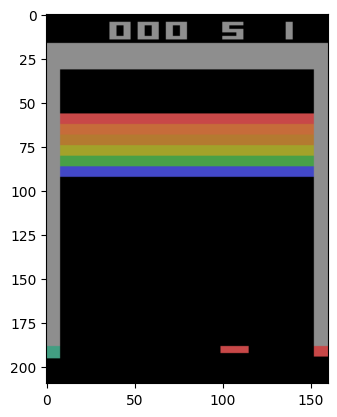

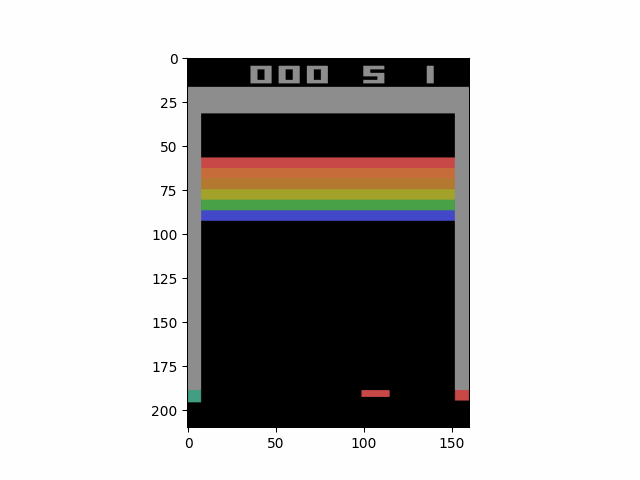

In [ ]:
### Plot some mini-batch at random

print('debug and test results')
if(False):
    print('plot some mini-batch at random')
    minibatch = my_replay_memory.get_minibatch()
    no_frames = my_replay_memory.agent_history_length
    fig = plt.figure(figsize=(MINIBATCH_SIZE*4, no_frames*4))
    for ii in range(no_frames):
        for iii in range(MINIBATCH_SIZE):
            plt.subplot(my_replay_memory.agent_history_length, MINIBATCH_SIZE, iii+ii*MINIBATCH_SIZE+1)
            plt.imshow(minibatch[0][iii, :, :, ii], cmap='jet')  # images are in minibatch[0] stored as minibatch[0].shape=(32, 84, 84, 4) ndarray
            plt.axis('off')
    plt.show()

env_test = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
action_meanings = env_test.unwrapped.get_action_meanings()

if(False):
    print('load model from directory model_bak')
    loaded_model = keras.models.load_model('model_bak')
    agent.model.set_weights(loaded_model.get_weights())

print('play game and draw results')
import matplotlib.animation as animation
images = []  # List to store the generated images

current_frame, _ = env_test.reset()  # single frame 84x84
current_frame_pre = pre_processing(current_frame)
# initialize
current_states = np.zeros(current_frame_pre.shape + (4,))
current_states[:, :, 0] = current_frame_pre.copy()

for jj in range(3):
    new_frame, reward, done1, done2, _ = env_test.step(action)
    current_states[:, :, jj+1] = pre_processing(new_frame)

plt.figure('play')
done = False
count = 0
max_frames_play = 20
while (not done) and (count < max_frames_play):
    count += 1
    current_qs_list = agent.model.predict(current_states[None, ...], verbose=0)  # input_shape=[1,84, 84, 4]
    best_action = np.argmax(current_qs_list)
    print('best action=', action_meanings[best_action], 'frame=', str(count))
    new_current_states = current_states.copy()
    new_current_states[:, :, :-1] = current_states[:, :, 1:]  # shift old states down a unit, put new one after
    new_frame, reward, done1, done2, _ = env_test.step(best_action)
    new_current_states[:, :, -1] = pre_processing(new_frame)
    done = done1 | done2
    images.append(new_frame)
    if(done):
        break
#  plt.imshow(new_frame)
#  plt.savefig("play_"+str(count)+".jpg")
#  plt.pause(0.1)

print('make animation')
fig, ax = plt.subplots()
# Function to update the plot for each frame of the animation
def update(frame):
    ax.imshow(images[frame])  # Display the corresponding image for the current frame

ani = animation.FuncAnimation(fig, update, frames=len(images), interval=400)
ani.save('animation.gif', writer='pillow')  # Requires pillow to be installed
plt.show()

from IPython.display import Image as Image_Ip
from IPython.display import display
display(Image_Ip(filename='animation.gif'))
#if('ipykernel' in sys.modules):#we are in Jupyter Notebook
#if('google.colab' in sys.modules):#we are in google colab